# Analyze Dataset

In [21]:
import os
import json

import numpy as np
import pandas as pd

import seqlogo

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from scipy.spatial.distance import hamming
from scipy.stats import entropy, probplot, norm

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

import seaborn as sns


## Matplotlib parameters

In [22]:
%matplotlib inline
with open('../figures/.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))
    
pltdir = '../figures'

### Load Dataset

In [23]:
dataset = pd.read_csv('../data/dataset.csv',sep=',', index_col=0)
dataset_train = dataset[dataset.testset==0]
dataset_test = dataset[dataset.testset==1]

y = dataset.groupby('name').agg({'dG (kcal/mol)': 'first'})
y_train = dataset_train.groupby('name').agg({'dG (kcal/mol)': 'first'})
y_test = dataset_test.groupby('name').agg({'dG (kcal/mol)': 'first'})

# Sequence information

seq_df = pd.read_csv('../data/aa_sequence.csv', sep=',', index_col=0)
seq_df.columns = seq_df.columns.astype(int)

### Plot free Energy

In [24]:
def dG2pKid(X, T=300, R=0.0019858775):
    return np.exp(X/T/R)
def pKid2dG(X, T=300, R=0.0019858775):
    return R*T*np.log(X)

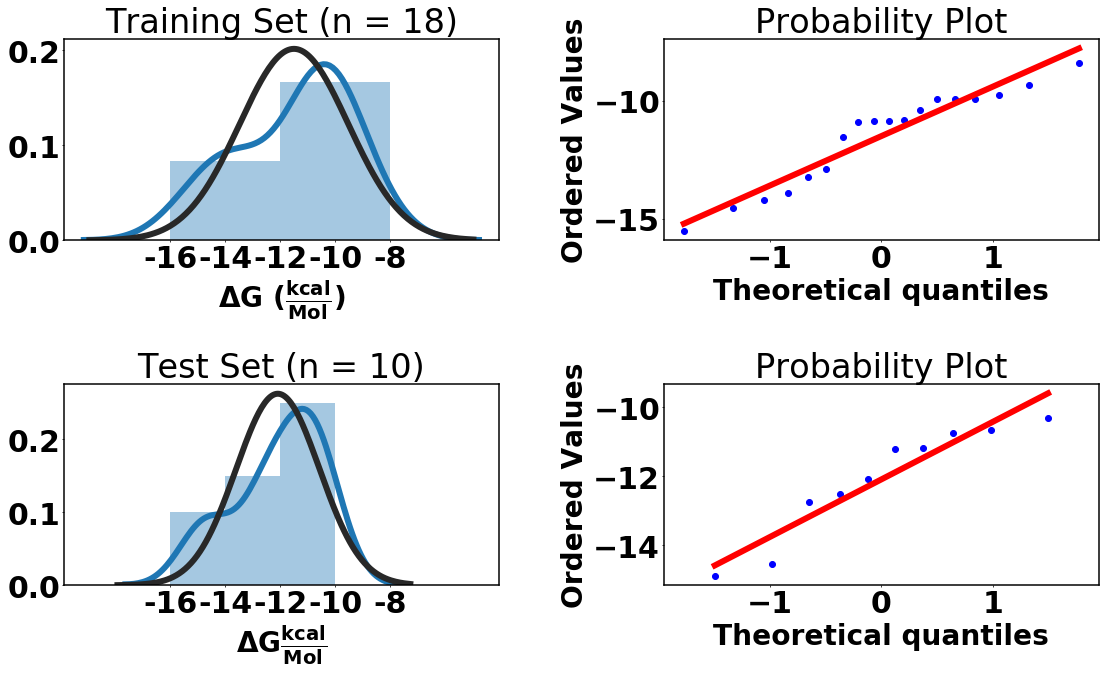

In [25]:
bins=np.arange(-16,-6, 2)
plt.figure(figsize=(16,10))

ax1 = plt.subplot(2,2,1)
plt.title('Training Set (n = {})'.format(y_train.shape[0]))
sns.distplot(y_train , fit=norm, bins=bins)
plt.xlabel('$\\rm \\Delta G\ (\\frac{kcal}{Mol})$')
plt.xticks(ticks=bins, labels=map(str, bins))

ax2 = plt.subplot(2,2,2)
_=probplot(np.array(y_train).reshape(-1), plot=plt)

ax3 = plt.subplot(2,2,3, sharex=ax1)

plt.title('Test Set (n = {})'.format(y_test.shape[0]))
plt.xlabel('$\\rm \\Delta G \\frac{kcal}{Mol}$')
plt.xticks(ticks=bins, labels=map(str, bins))
sns.distplot(y_test , fit=norm, bins=bins)

ax4 = plt.subplot(2,2,4, sharex=ax2)
_=probplot(np.array(y_test).reshape(-1), plot=plt)

plt.tight_layout()
plt.savefig(os.path.join(pltdir, 'train_test_split.png'), dpi=300)

## Sequence Analysis

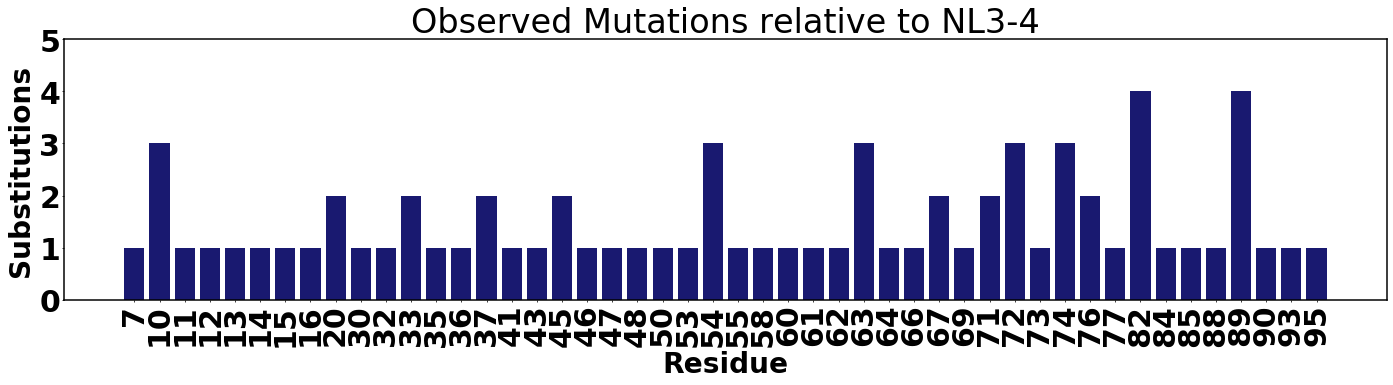

In [26]:
variants = np.asarray([seq_df[i].nunique() for i in range(1, 100, 1)])
mutations = variants[variants>1]-1
variable_residues = [i for i, n in zip(list(range(1,100,1)), variants) if n > 1]

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(np.arange(len(mutations)), mutations, color='midnightblue')
ax.set_xlabel('Residue')
ax.set_ylabel('Substitutions')
ax.set_xticks(np.arange(len(mutations)))
ax.set_xticklabels(map(str,variable_residues), rotation=90)
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(map(str,list(range(0,6,1))))
ax.set_title('Observed Mutations relative to NL3-4')
plt.tight_layout()
plt.show()

In [27]:
aa = list('ACDEFGHIKLMNPQRSTVWY')
seq_ppm = pd.DataFrame(columns=aa)
for pos in  seq_df.columns:
    symbols, counts = np.unique(seq_df[pos], return_counts=True)
    if len(counts) == 1:
        continue
    frequency = counts/np.sum(counts)
    for s,f in zip(symbols, frequency):
        seq_ppm.loc[pos, s] = f

In [28]:
seq_ppm.fillna(0, inplace=True)

In [29]:
ppm = seqlogo.CompletePm(pfm = None, ppm = seq_ppm, pwm = None, background = None, pseudocount = None,
                 alphabet_type = 'AA', alphabet = None, default_pm = 'ppm')

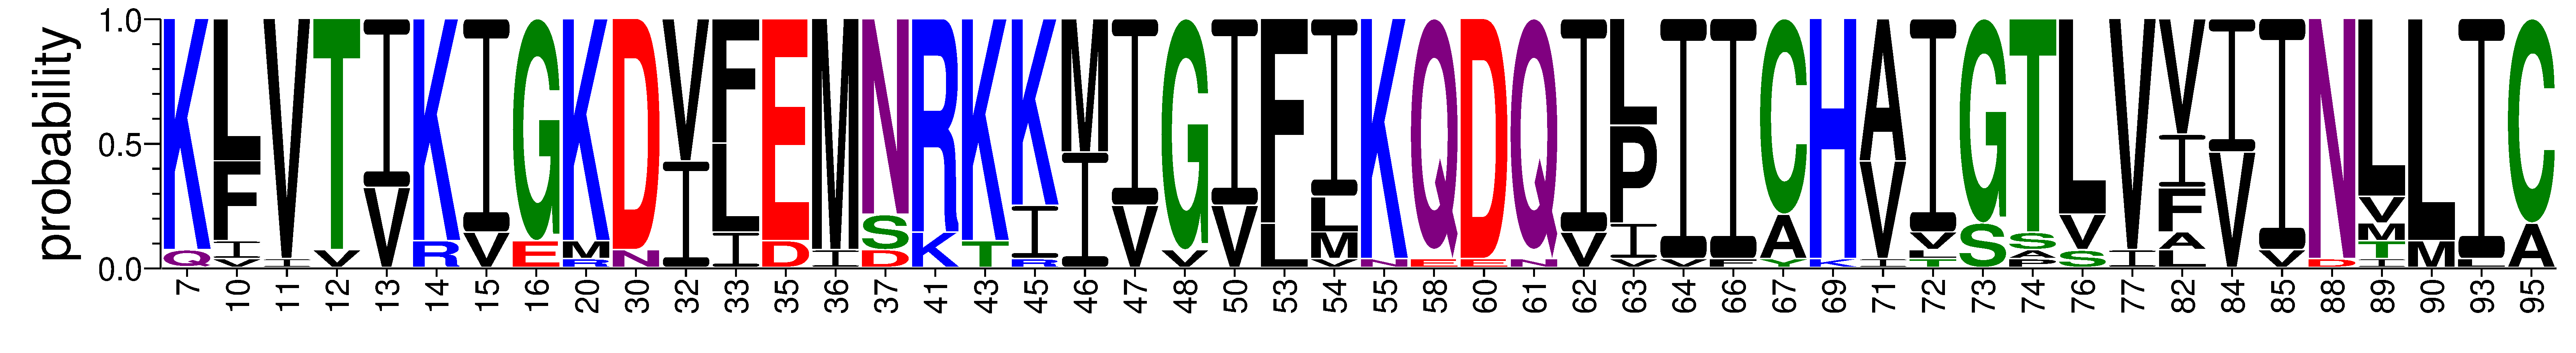

In [30]:
###  Sequence logo one liner
seqlogo.seqlogo(ppm, color_scheme='chemistry', ic_scale = False, 
                format = 'png', size = 'xlarge', filename=os.path.join(pltdir, 'seq_logo2.png'),
                annotate=list(map(str,seq_ppm.index)),fontsize=16, number_fontsize=10,ticmarks=2.0,
                rotate_numbers=True, resolution=600, S=1., stacks_per_line=48)

## Perform Hierarchical Clustering

In [31]:
dist_matrix = np.zeros((seq_df.shape[0], seq_df.shape[0]))
for i in range(0,seq_df.shape[0]-1):
    for j in range(i+1,seq_df.shape[0]):
        d = hamming(seq_df.iloc[i,], seq_df.iloc[j,])
        dist_matrix[(i, j)] = d
        dist_matrix[(j, i)] = d

In [32]:
Z = linkage(dist_matrix,'complete')

/home/flo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


## Maximum difference between variants (1-Idendity)

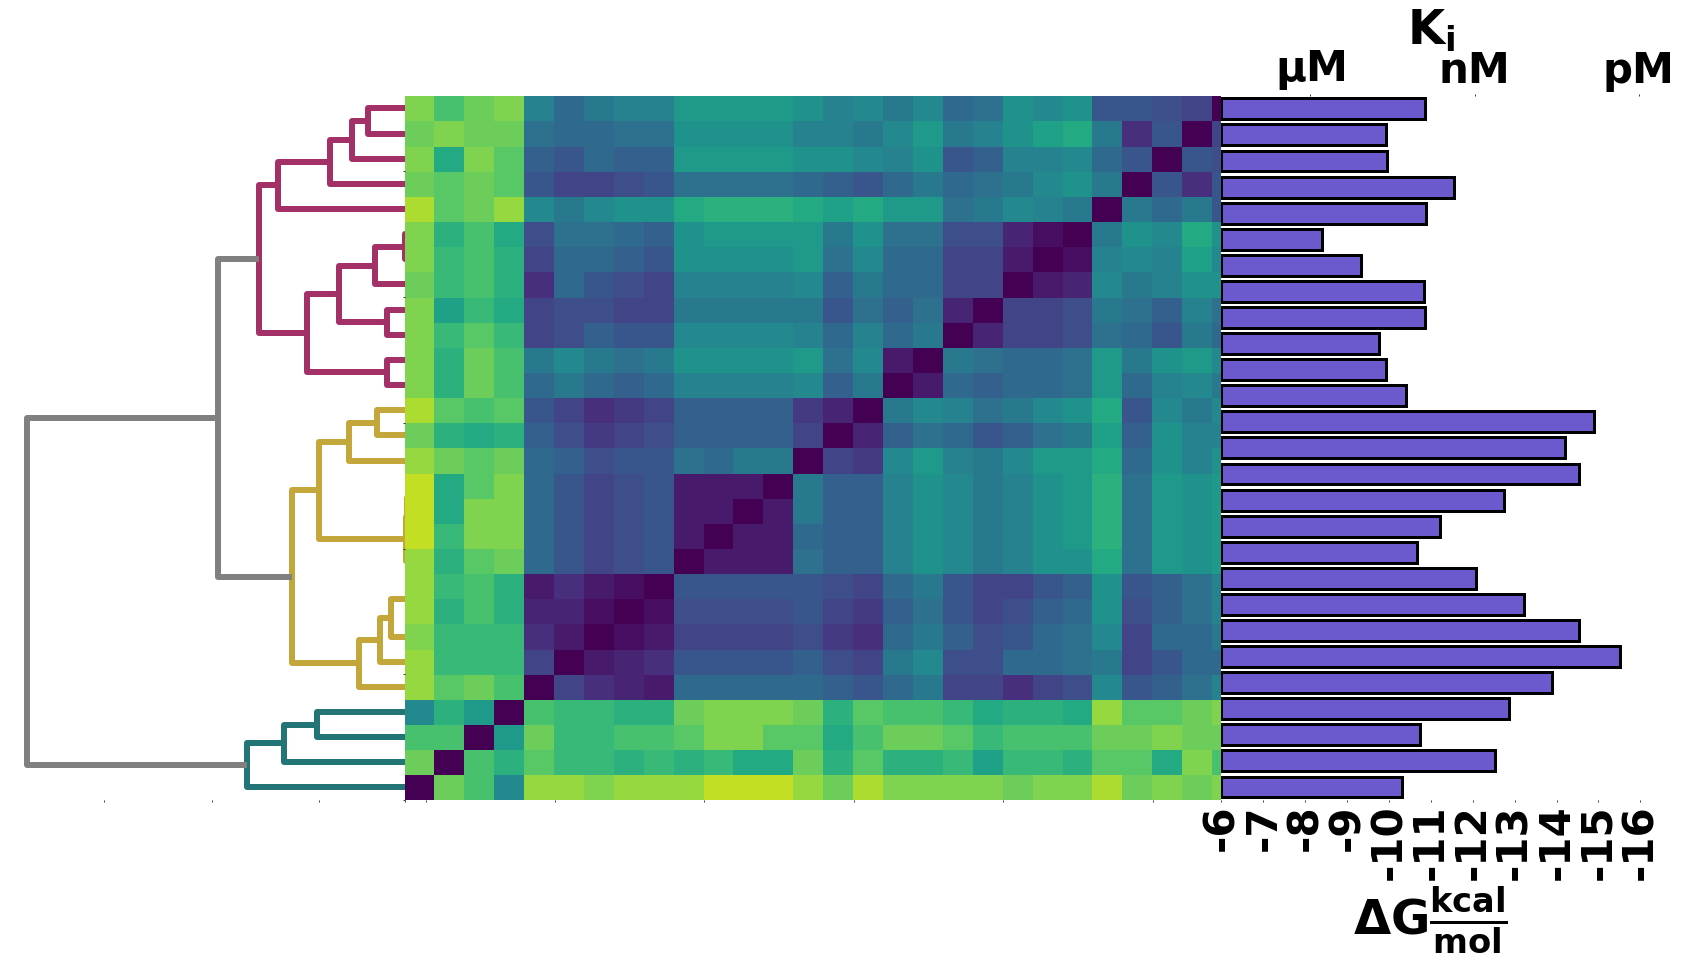

In [33]:
figsize=(22,12)
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(1, 3,width_ratios=[0.5, 1, .5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 6
set_link_color_palette(['#237575', '#C3A73A', '#A33167'])

#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(26,12))
#dend = dendrogram(Z, ax=ax1, orientation='left',labels=seq_df.index, leaf_font_size=24, color_threshold=.42)   
dend = dendrogram(Z, ax=ax1, orientation='left', 
                  leaf_font_size=24, color_threshold=.42, above_threshold_color='Gray',
                  labels=['', ]*len(seq_df))
ax1.set_xticklabels([''])

heatmap = ax2.pcolor(dist_matrix[dend['leaves']].T[dend['leaves']].T,vmin=0., vmax=0.3)

#ax1.yaxis.tick_right()
#ax1.set_yticks([x[1] for x in cluster_ticks])
#ax1.set_yticklabels(['{}'.format(x[0]) for x in cluster_ticks],fontsize=12)
ax2.set_xticklabels([''])
ax2.set_yticklabels([''])


#ax1.set_title('Average Linkage Clustering', fontsize=30)
#ax2.set_title('1-Sequence Identity', fontsize=30)
#cbar = plt.colorbar(heatmap)
#cbar.set_label('1-Sequence Identity', fontsize=30)
#cbar.ax.tick_params(labelsize=24)


ax3.barh(ax1.get_yticks(), (y.loc[seq_df.index].iloc[dend['leaves']]+6).values.reshape(-1),
         height=8, align='center',color='#6A5ACD', alpha=1., zorder=10, edgecolor='black', linewidth=3)

ax3.set_xlabel('$\\rm \\Delta G \\frac{kcal}{mol}$', fontsize=48)
ax3.set_ylim((10, 280))

ax4 = ax3.twiny()

ax3.set_xlim((0, -10.5))
ax3.set_xticks(list(range(-10, 1)))
ax3.set_xticklabels(list(map(str,list(range(-16, -5)))), rotation=90, fontsize=42)

#ax2.set_yticks(ax1.get_yticks())
#ax2.set_yticklabels(dG.iloc[dend['leaves']].index, fontsize=24)
ax3.set_yticks([])


ax4.set_xticks([x+6 for x in list(map(pKid2dG, [1e-12, 1e-9, 1e-6]))])
ax4.set_xticklabels(['pM','nM','$\\rm \mu M$'], fontsize=42)
ax4.set_xlim((0, -10.5))
ax4.set_xlabel('$\\rm K_{i}$', fontsize=48)   

for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig.tight_layout(pad=-1.5)

#plt.tight_layout()
plt.savefig(os.path.join(pltdir, 'sequence_clustering'),dpi=plt.gcf().dpi, bbox_inches = 'tight')

### Generate separate colorbar

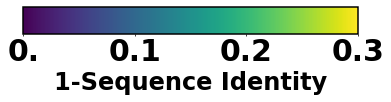

In [34]:
fig, ax = plt.subplots(figsize=(6,0.5))
col_map = plt.get_cmap('viridis')
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal', ticks=np.linspace(0, 1, 4))
cbar.ax.set_xticklabels(['0.', '0.1', '0.2', '0.3']) 
cbar.set_label('1-Sequence Identity', fontsize=24)
plt.savefig(os.path.join(pltdir, 'sc_colorbar.png'),dpi=plt.gcf().dpi, bbox_inches = 'tight')
